# Examples for network2graph

In [1]:
using Qaintensor
using LinearAlgebra
using StatsBase: sample
using Qaintessent

In [2]:
# some setup
# copied from MPS branch
function ClosedMPS(T::AbstractVector{Tensor})
    l = length(T)
    @assert ndims(T[1]) == 2
    for i in 2:l-1
        @assert ndims(T[i]) == 3
    end
     @assert ndims(T[l]) == 2

    contractions = [Summation([1 => 2, 2 => 1]); [Summation([i => 3,i+1 => 1]) for i in 2:l-1]]
    openidx = reverse([1 => 1; [i => 2 for i in 2:l]])
    tn = TensorNetwork(T, contractions, openidx)
    return tn
end

Base.ndims(T::Tensor) = ndims(T.data)
Base.copy(net::TensorNetwork) = TensorNetwork(copy(net.tensors), copy(net.contractions), copy(net.openidx))

function shift_summation(S::Summation, step)
   return Summation([S.idx[i].first + step => S.idx[i].second for i in 1:2])
end

crand(dims...) = rand(ComplexF64, dims...)

# generate tensor network for benchmarking
""" Compute the expectation value of a random MPS when run through circuit `cgc`"""
function expectation_value(cgc::CircuitGateChain{N}; is_decompose = false) where N
    
    tensors = Tensor.([crand(2,2), [crand(2,2,2) for i in 2:N-1]..., crand(2,2)])
    T0 = ClosedMPS(tensors)
    
    T = copy(T0)
    tensor_circuit!(T, cgc, is_decompose = is_decompose)
    
    # measure
    T.contractions = [T.contractions; shift_summation.(T0.contractions, length(T.tensors))]
    for i in 1:N
        push!(T.tensors, T0.tensors[N+1-i])
        push!(T.contractions, Summation([T.openidx[end], (length(T.tensors) => T0.openidx[N+1-i].second)]))
        pop!(T.openidx)
    end
    T
end

expectation_value

# Graph of a tensor network

Let's convert the tensor

```
    1 □—————□ 4
      |     |
    2 □—————□ 3
```

to a graph:

In [3]:
A = [1. 0; 0 1]

tensors = Tensor.([copy(A) for i in 1:4])
contractions = Summation.([[1=>2, 2=>1],
                           [2=>2, 3=>1],
                           [3=>2, 4=>1],
                           [4=>2, 1=>1]])
openidx = Pair[]
TN = TensorNetwork(tensors, contractions, openidx)

G, edge_idx = network_graph(TN)

({4, 4} undirected simple Int64 graph, Dict((1, 2) => [1],(2, 3) => [2],(1, 4) => [4],(3, 4) => [3]))

The output is a `Graph` from package `LightGraphs.jl`. Since this implementation doesn't support several edges between same nodes, we find the indices of the contractions corresponding to an edge of the graph in the dictionary `edge_idx`:

In [4]:
edge_idx[(2,3)]

1-element Array{Int64,1}:
 2

We can plot the graph using the package `GraphPlot`. Here we plot the verties as well as the indices of the contractions corresponding to each edge. 

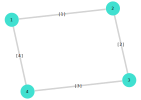

In [5]:
using LightGraphs: edges, nv, Graph
using GraphPlot
using Random: seed!

seed!(1)
gplot(G, nodelabel = 1:4, edgelabel = [edge_idx[Tuple(e)] for e in edges(G)])

We can plot more complex tensor networks and visualize their structure using color masks. Here, the circuit for the QFT with no decompose applied:

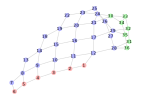

In [6]:
using Colors

seed!(7)

N = 6
cgc = qft_circuit(N)

TN = expectation_value(cgc, is_decompose = false)
G, _ = network_graph(TN)

alpha = 0.3
# Different colors for input, output and gate tensors
colors = fill(RGBA(0,0,1,alpha), nv(G))
colors[1:N] .= RGBA(1,0,0,alpha)
colors[end-N:end] .= RGBA(0,1,0,alpha)

gplot(G,  nodelabel=1:nv(G), nodefillc = colors)

And with decompose:

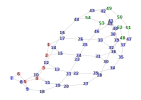

In [7]:
seed!(3)

N = 6
cgc = qft_circuit(N)

TN = expectation_value(cgc, is_decompose = true)
G, _ = network_graph(TN)

alpha = 0.3
# Different colors for input, output and gate tensors
colors = fill(RGBA(0,0,1,alpha), nv(G))
colors[1:N] .= RGBA(1,0,0,alpha)
colors[end-N:end] .= RGBA(0,1,0,alpha)

gplot(G,  nodelabel=1:nv(G), nodefillc = colors)